In [1]:
library(tidyverse)
options(repr.plot.height=6, repr.plot.width=10)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.3
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# STATS 604 
## Week 5: Solar weather and GOES data

https://www.youtube.com/watch?v=oOXVZo7KikE

## About the data source
- The Geostationary Operational Environmental Satellites (GOES) are a series of satellites in geostationary orbit.
- They collect:
    - [Terrestrial weather data](https://www.star.nesdis.noaa.gov/goes/) (cloud cover, storms, hurricanes, etc.)
    - Atmospheric observations (temperature, humidity, solar radiation)
    - [Space weather data](https://www.swpc.noaa.gov/products/goes-x-ray-flux) (our focus)

## Space weather
https://www.youtube.com/watch?v=oOXVZo7KikE

## The raw data
(Importing in R turned out to be difficult so I switched over to Python)

In [2]:
goes_2018_12 <- read_csv("goes_2018_12.csv.gz")

New names:
• `` -> `...1`
Rows: 2288038 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): ...1, Year, Month, Day, Time, Flux1, Flux2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Plotting the raw data
To start with, how can we visualize our data? (It is very large/dense.) We will start by assigning an "absolute time" to each observation:


In [100]:
library(lubridate)
goes_2018_12 %>% 
    mutate(t0 = as.numeric(make_datetime(Year, Month, Day, 0, 0, 0)),
           t = t0 + Time,
           Time = as.POSIXct(t, origin="1970-01-01", tz="UTC")) -> df_wide
df_wide %>% pivot_longer(Flux1:Flux2) -> df

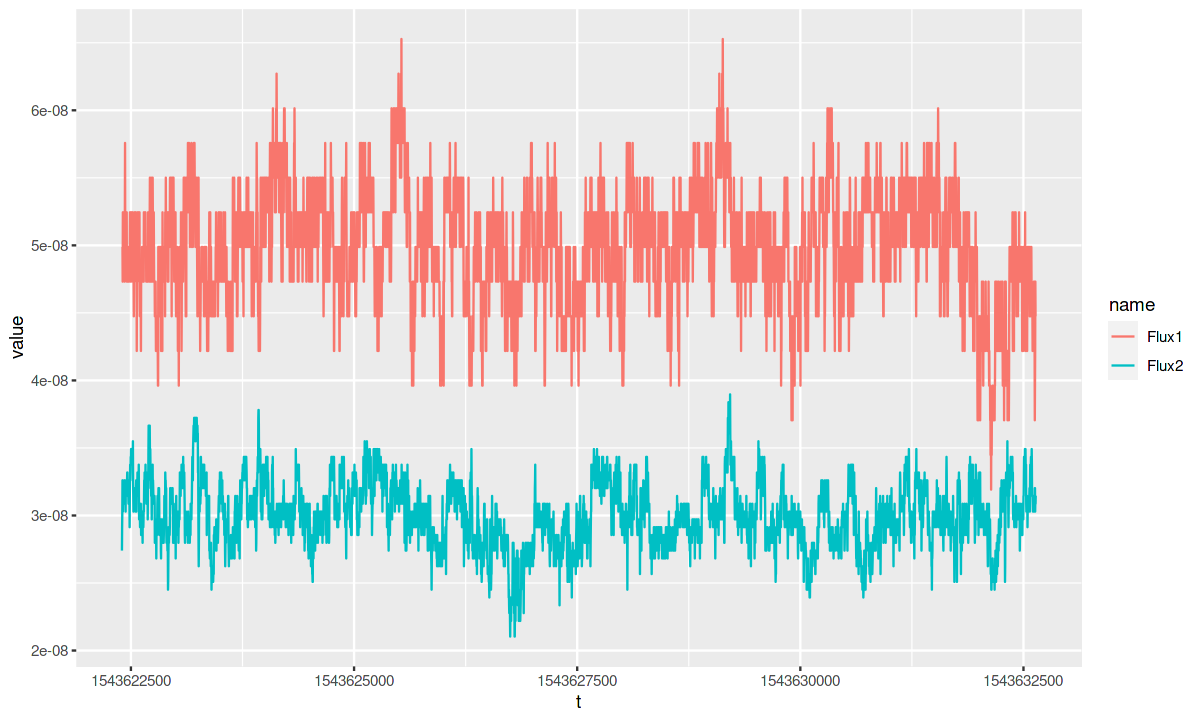

In [93]:
df %>% filter(Day == 1) %>% 
    head(10000) %>% 
    ggplot(aes(x=t, y=value, color=name)) + geom_line()

## What is the relationship between Flux1 and Flux2?


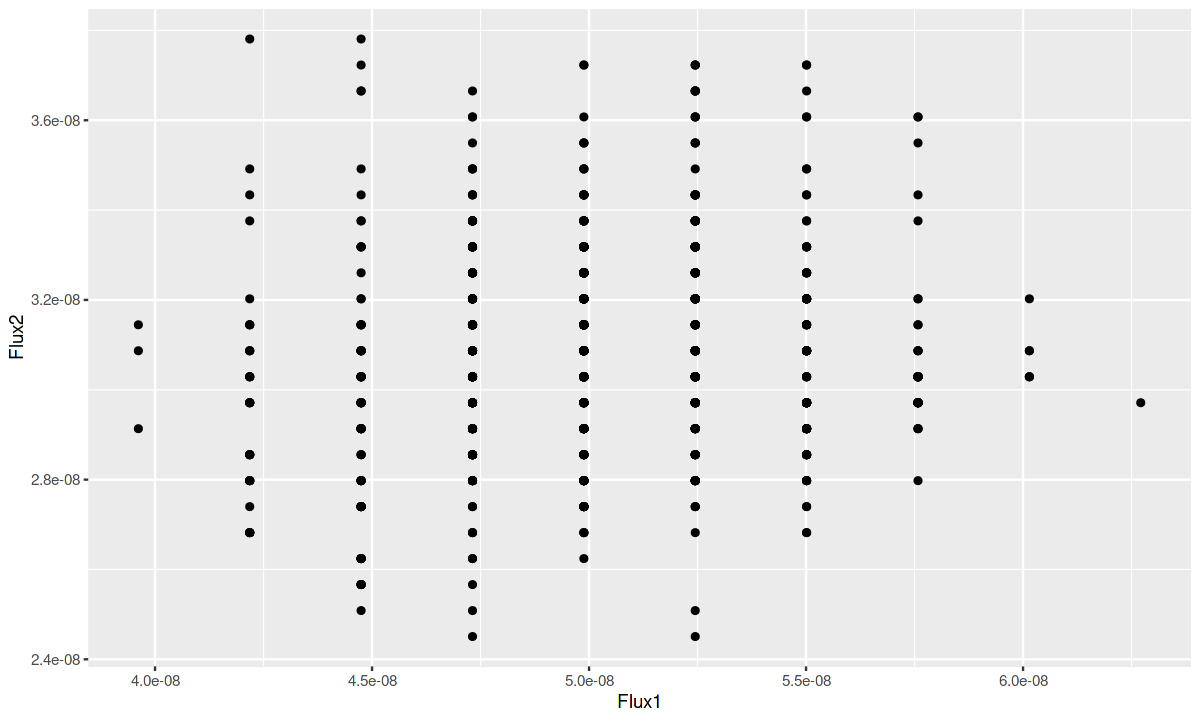

In [102]:
df_wide %>% slice(1:1000) %>% ggplot + geom_point(aes(x=Flux1, y=Flux2))

There is too much noise so we need to use averaging to try and get a sense of the underlying signal:

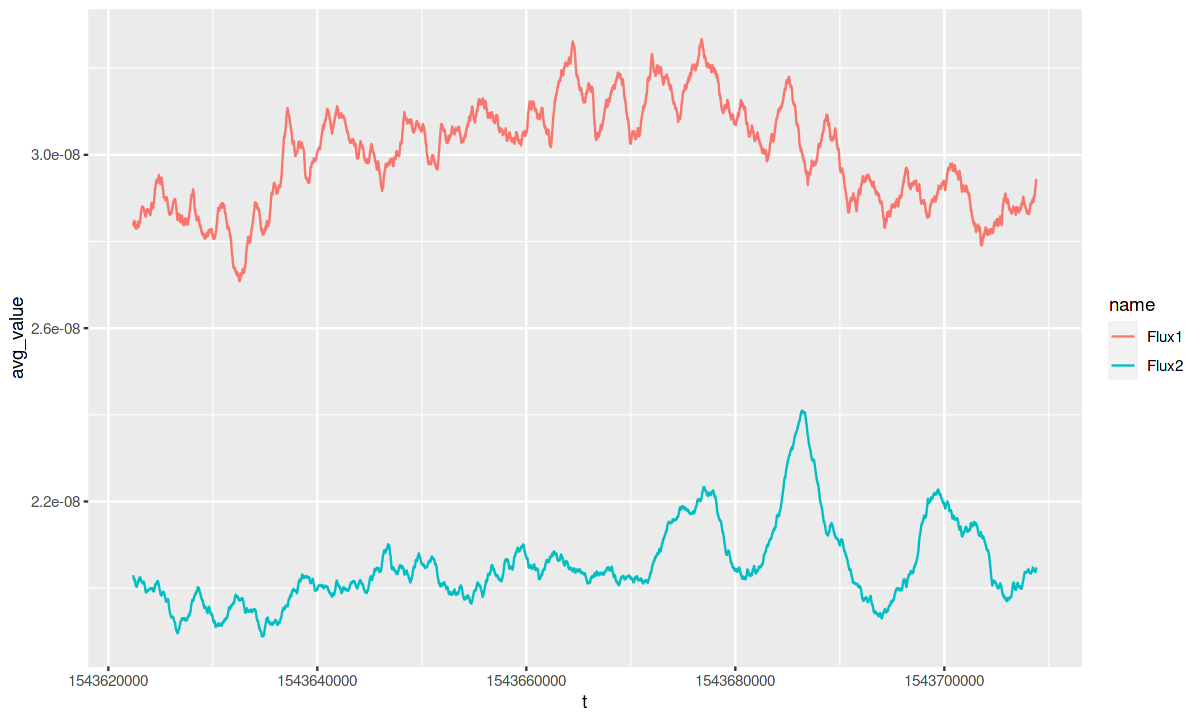

In [61]:
library(slider)
df %>% 
    filter(Day == 1) %>% 
    arrange(name, t) %>% 
    group_by(name) %>% 
    mutate(avg_value = slide_dbl(value, mean, .before=1000, .after=1000)) %>% 
    ggplot + geom_line(aes(x=t, y=avg_value, color=name))

## Daily averages
To get a very "high" level picture of the data, we can do the usual thing and summarize by each day:

`summarise()` has grouped output by 'Day'. You can override using the `.groups` argument.


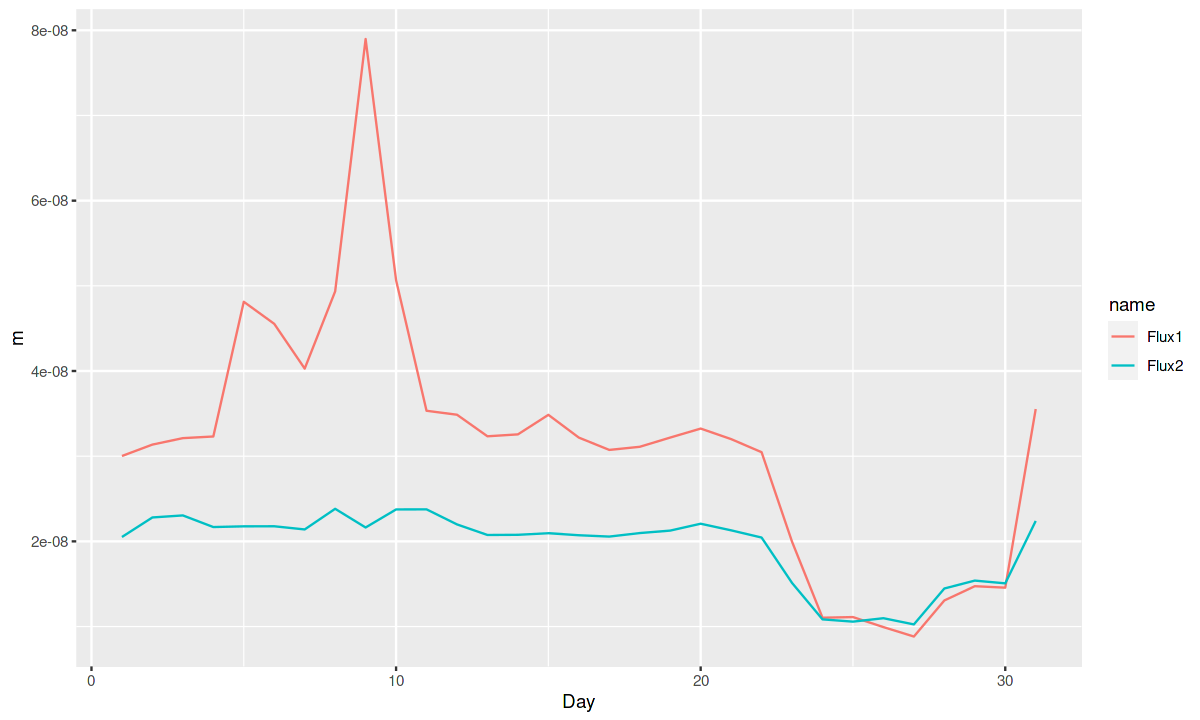

In [64]:
df %>% group_by(Day, name) %>% summarize(m=mean(value)) %>% 
    ggplot + geom_line(aes(x=Day, y=m , color=name))

## Correlations
How correlated are the two measurements?

Warning message:
“Values from `value` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} %>%
  dplyr::group_by(...1, Year, Month, Day, Time, t0, t, name) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(Flux1, Flux2)`.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1594 rows containing non-finite values (`stat_density2d()`).”


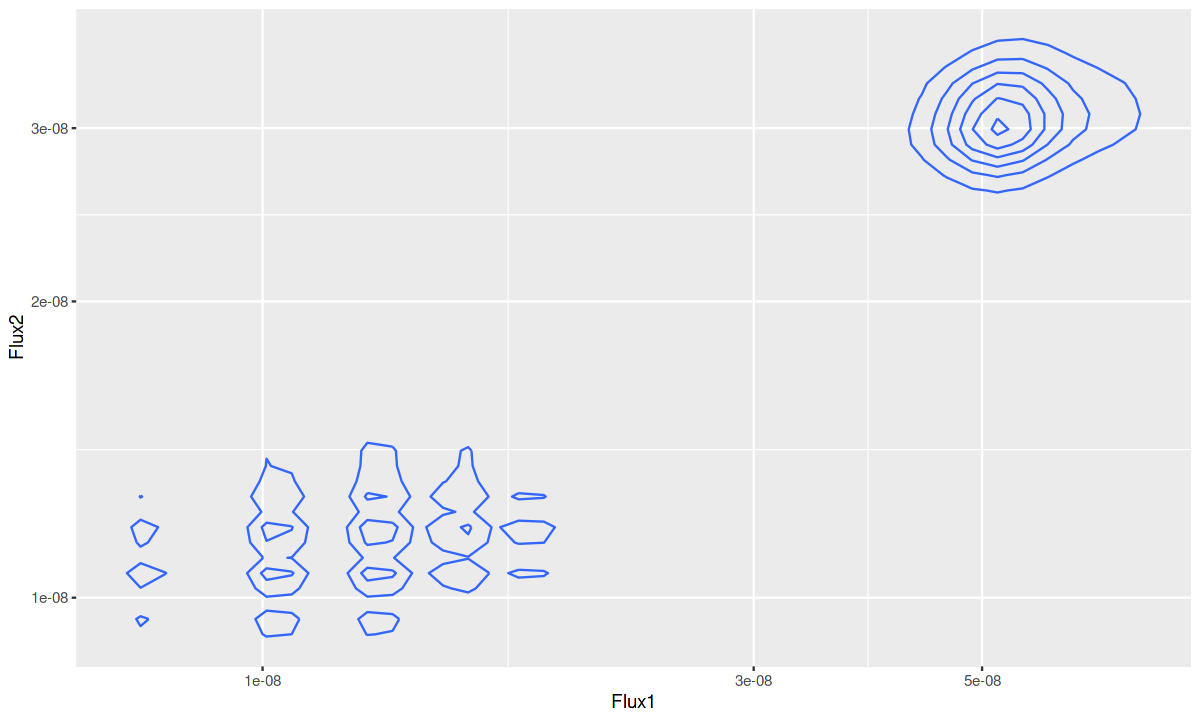

In [83]:
df %>% pivot_wider(values_from=value, names_from=name) %>% unnest %>% 
    ggplot + geom_density_2d(aes(x=Flux1, y=Flux2)) + scale_x_log10() + 
    scale_y_log10()

## What is the distribution of Flux? 
- What is the marginal distribution of Flux?
- Are the distributions of Flux1 and Flux2 the same or different?

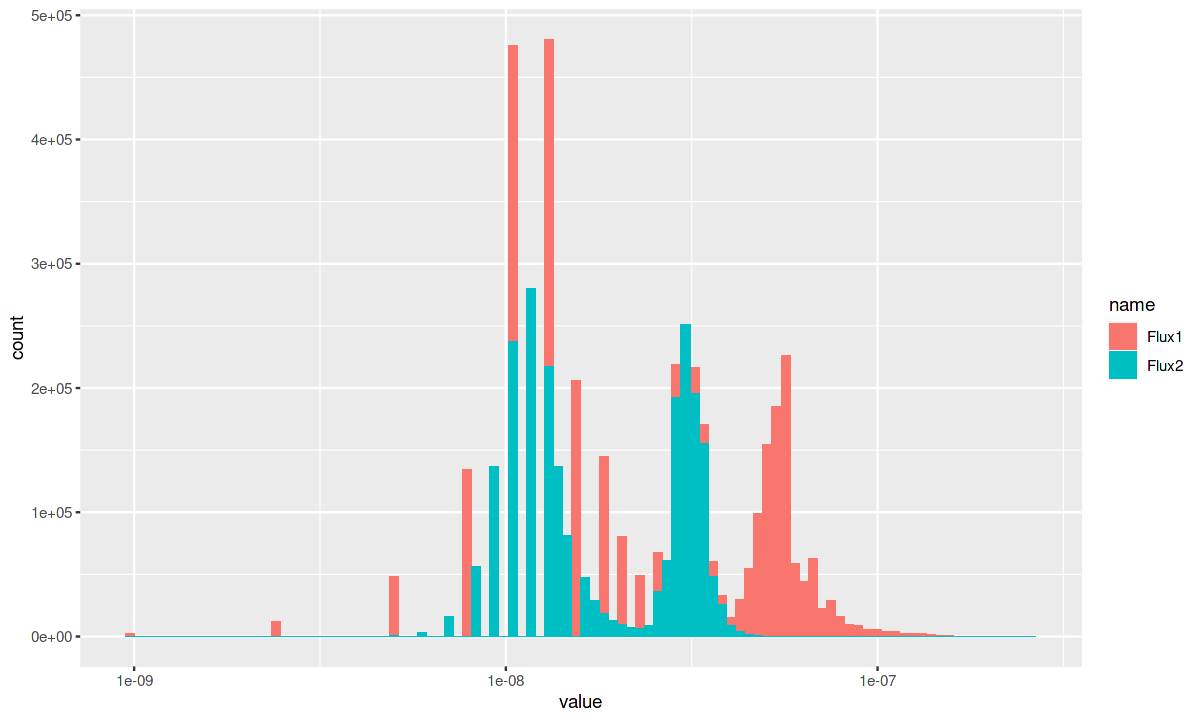

In [73]:
filter(df, value > 0) %>%  ggplot() + geom_histogram(aes(x=value, fill=name), bins=100) + scale_x_log10()

## Is it $AR(k)$?

In [90]:
df %>% arrange(name, t) %>% group_by(name) %>% mutate(dv = c(NaN, diff(value))) %>% head
    ggplot + geom_histogram(aes(x = dv, fill = name), bins=100)

...1,Year,Month,Day,Time,t0,t,name,value,dv
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<int>,<dbl>,<chr>,<dbl>,<dbl>
0,2018,12,1,2018-11-30 23:59:59,1543622400,1543622399,Flux1,4.9881e-08,NaN
0,2018,12,1,2018-11-30 23:59:59,1543622400,1543622400,Flux1,1.0329e-08,-3.95520e-08
1,2018,12,1,2018-12-01 00:00:01,1543622400,1543622401,Flux1,4.9881e-08,3.95520e-08
1,2018,12,1,2018-12-01 00:00:01,1543622400,1543622402,Flux1,7.7058e-09,-4.21752e-08
2,2018,12,1,2018-12-01 00:00:03,1543622400,1543622403,Flux1,4.9881e-08,4.21752e-08
2,2018,12,1,2018-12-01 00:00:03,1543622400,1543622404,Flux1,1.0329e-08,-3.95520e-08


NULL

## Perodicity in the data
One question we have looking at these plots is whether/to what extent the data are "periodic". To measure this we can look at a "periodogram":

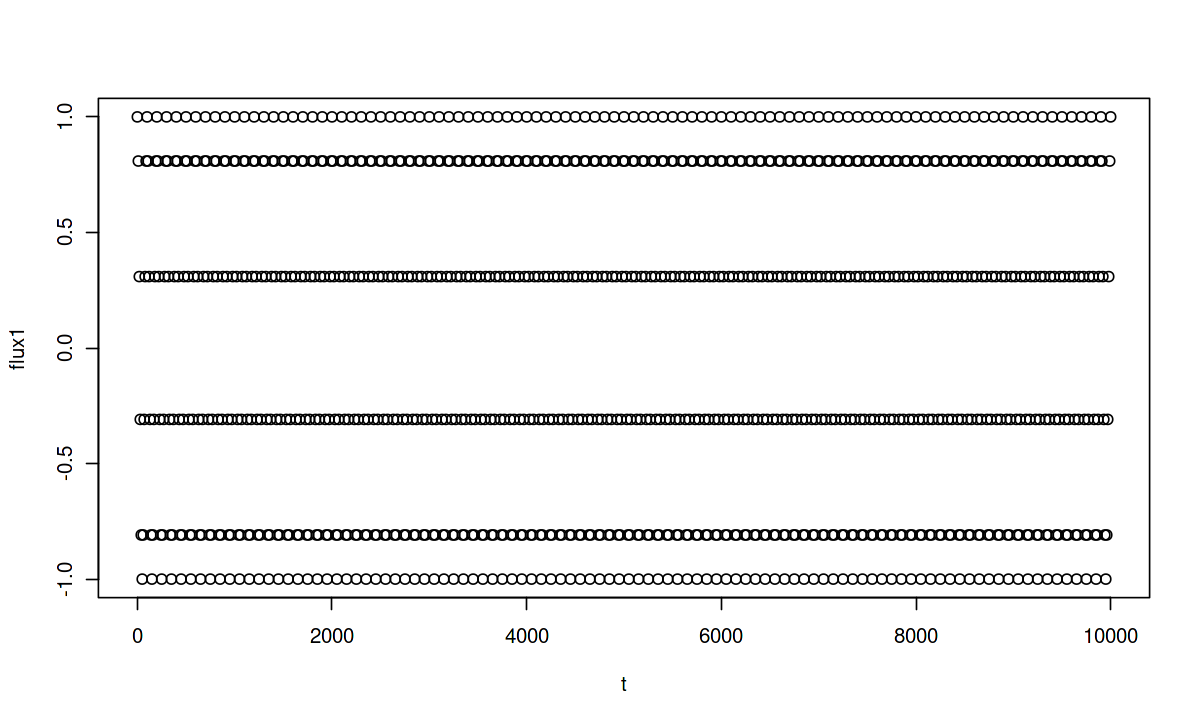

In [54]:
period = 100
w = 1 / period
t <- seq(0, 10000, 10)
flux1 = cos(w*2*pi*t) + 0.0*rnorm(n=length(t))
plot(t, flux1)

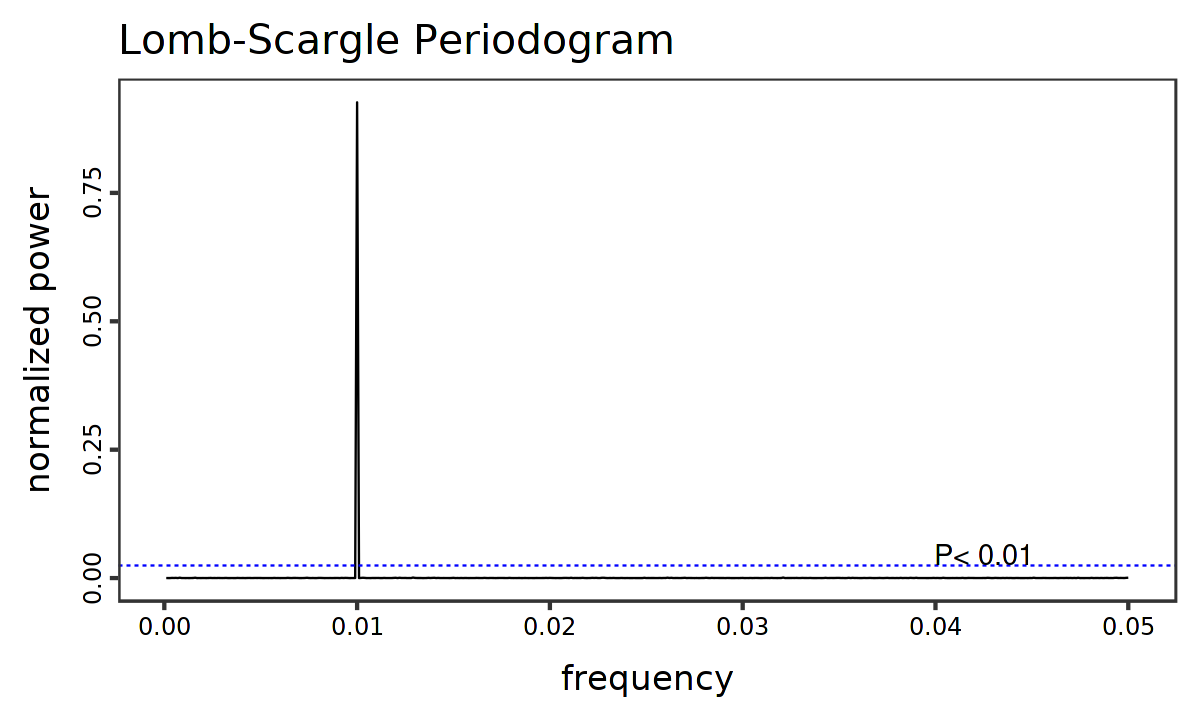

In [38]:
# install.packages("lomb")
library(lomb)

period = 100
w = 1 / period
t <- seq(0, 10000, 10)
flux1 = cos(w*2*pi*t) + 0.2*rnorm(n=length(t))
lsp(flux1, t)

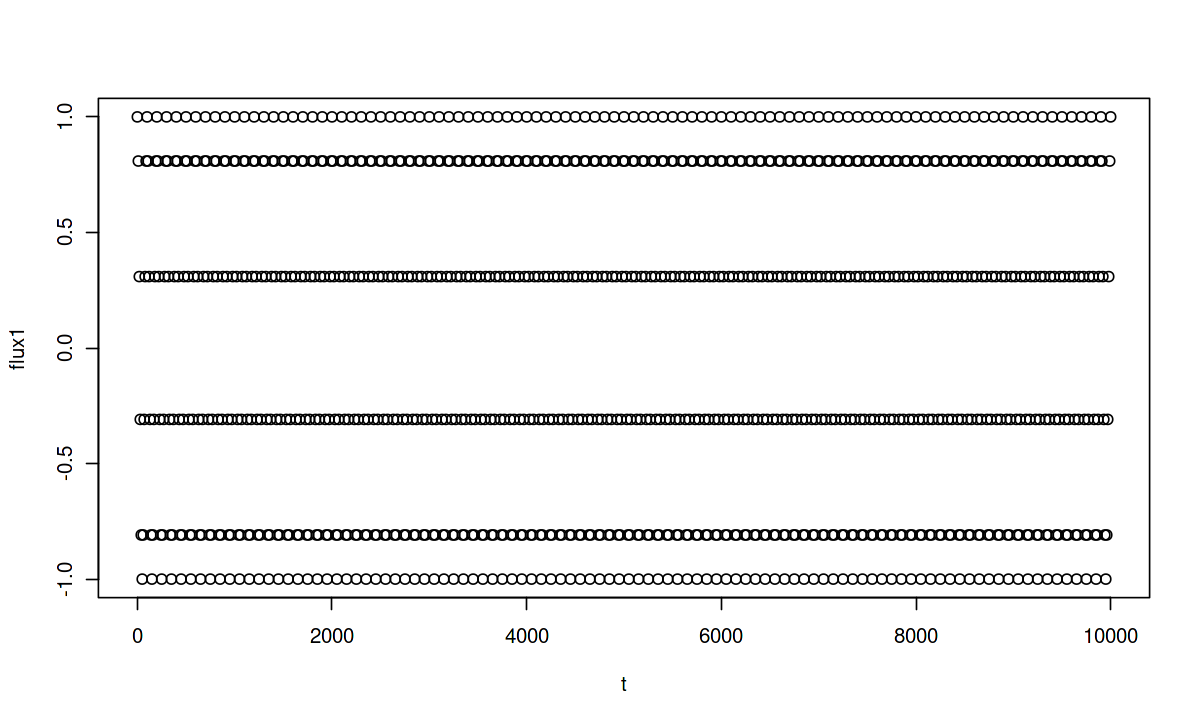

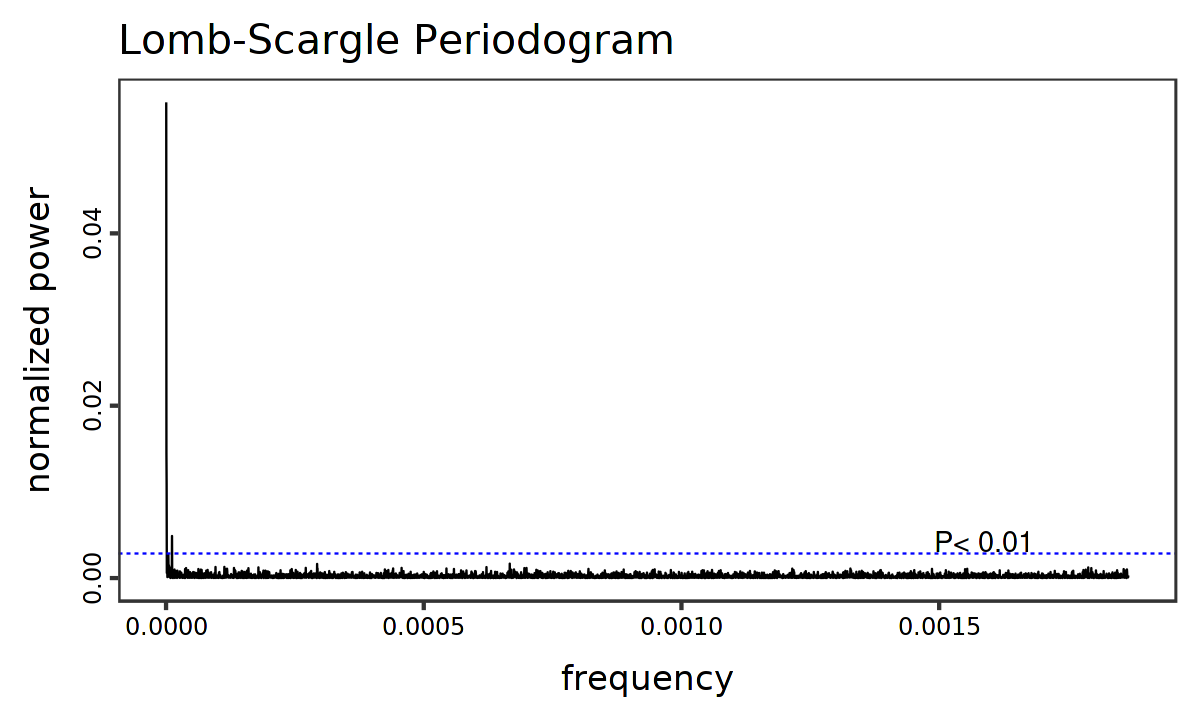

In [53]:
df_small <- sample_n(df, 10000)
lsp(df_small$Flux2, df_small$t)